In [48]:
#import all packages 
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import copy
import time
from sklearn.decomposition import PCA
import scanpy as sc
import pandas as pd

In [49]:
#take maxixmum score of weighted distances² as a new centroid point
def new_centroid(array_copy, counter_already_chosen, centroids):
    
    #get the max. distance
    max_list= np.argmax(array_copy, axis=0)
    
    row = max_list[3]
    centroids[counter_already_chosen, 0] = array_copy[row, 0]
    centroids[counter_already_chosen, 1] = array_copy[row, 1]
    
    return centroids
    
#compute weighted distance   
def sum_up_and_weight(array_copy):
    
    #for each cenroid
    summe = 0
    
    #sum distances for linked to closest centorid for each centroid
    for counter_array, row in enumerate(array_copy):
        summe += row[3]
        
    #weightens distance²
    for counter_array, row in enumerate(array_copy):
        row[3] = row[3] / summe
    
    return array_copy
    
    
#measures distance between a data x-/ y-value and centroid x-/ y-value and returns distance²
def distance_to_point_square(x, y, x_centroid, y_centroid):
    
    del_x = x-x_centroid 
    del_y = y-y_centroid
    
    del_x = -del_x if del_x<0 else del_x
    del_y = -del_y if del_y<0 else del_y
    
    distance = del_x**2 + del_y**2
        
    return distance

#measure distance to each centroid and remember closest centroid + distance²
def measure_distance_and_centroid(array_copy, centroids):
    for counter_array, row in enumerate(array_copy):

        #measure distance to each entroid
        for counter_centroid, value in enumerate(centroids):
            distance_square = distance_to_point_square(row[0], row[1], value[0], value[1])
            value[2] = distance_square
            
        #get index of closest centroid and write it into array + distance
        min_list= np.argmin(centroids, axis=0)
        
        #min_list[2] = point of the closest centroid
        #min_list[1] = is the same point as referred
        row[2] = centroids[min_list[2], 7]
        row[3] = centroids[min_list[2], 2]
        
    return array_copy


#initialization of centroids with mean++ algorithm
def init_centroids_new(array, centroids, k_mean):    
   
    #take first centroid randomly from dataset
    max_number, temp = array.shape
    first = random.randint(0, max_number)
    centroids[0, 0] = array[first, 0]
    centroids[0, 1] = array[first, 1]
    
    array_copy = copy.deepcopy(array)
    #because we only need x , y , closest centroid, distance²/ weighted distance² for the array:
    #splice array to get the first 4 columns of every data point
    array_copy = array_copy[:,:4]

    #write the number of the centroids into the array of centroids
    counter_number = 1
    for counter, row in enumerate(centroids):
        row[7] = counter_number
        counter_number += 1
     
    #keep track of how many centroids are already chosen
    counter_already_chosen = 1

  
    #do the mean++ algorithm untill all of the centroids are assigned to one data point
    while counter_already_chosen < k_mean:
        
        #measure distance to each centroid and remember closest centroid + distance²
        measure_distance_and_centroid(array_copy, centroids)
        
        #compute weighted distance
        sum_up_and_weight(array_copy)
        
        #get new centroid
        new_centroid(array_copy, counter_already_chosen, centroids)
        counter_already_chosen += 1
    
    #reset values occupied in centroids
    for counter, row in enumerate(centroids):
        row[2] = 0
    
    return centroids

In [50]:
#load data through PCA and return the array containing all the points
def load_data_and_PCA(k_mean):
    
    #read the data
    adata = sc.read_10x_mtx(
        r'C:\Users\user\Desktop\Data Analysis\filtered_gene_bc_matrices\hg19',  
        var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
        cache=True)   

    x = adata._X.todense()

    p=PCA(n_components = 100)
    p.fit(x)
    x_transformed = p.transform(x)
    
    runter, breit = x_transformed.shape
    
    #initialize array
    array = np.zeros((runter, k_mean + 3))
    
    i=0
    for counter_array, row in enumerate(array):
        row[0] = x_transformed[i, 0]
        row[1] = x_transformed[i, 1]
        i += 1
        
    return array


In [51]:
#load data "the old way" clusters have random middle points with
#the number_of_points and the respective distribution around the middle point
#cluster_guessed = how many centers should the data have
def init_array_old(array, cluster_guessed, number_of_points, distribution):
    
    #make data generation variable by use of lists for x and y values
    
    #generate x-values
    data_x_cluster = []
    for counter_cluster in range(0, cluster_guessed):
        
        middle = random.uniform(0,50)
        print("Middle of x nr." + str(counter_cluster) + " : " + str(counter_cluster) + " is: " + str(middle))
        left = middle - distribution
        right = middle + distribution
        
        for i in range(0, number_of_points):
            temp = random.uniform(left, right)
            data_x_cluster.append(temp)
         
    #generate y values
    data_y_cluster = []
    for counter_cluster in range(0, cluster_guessed):
        
        middle = random.uniform(0, 50)
        print("Middle of y nr." + str(counter_cluster) + " : " + str(counter_cluster) + " is: " + str(middle))
        down = middle - distribution
        top = middle + distribution
        
        for i in range(0, number_of_points):
            temp = random.uniform(down, top)
            data_y_cluster.append(temp)
    
    
    #go through both lists and write the values into the array
    i=0
    for counter_array, row in enumerate(array):
        row[0] = data_x_cluster[i]
        row[1] = data_y_cluster[i]
        i += 1
        
    
    #randomize array for miniBatch
    np.random.shuffle(array)
    
    
    return array

In [52]:
#function which prints all points in their colour corresbonding to their closest centroid
#in first run through every point is printed in black --> no assigned centroids yet
def plot_array(array, centroids):
    
    #label plot
    plt.xlabel('x-value')
    plt.ylabel('y-value')
    
    #dictionairy for colours 
    dictionairy = {0 : 'black',
                   1 : 'darkblue', 
                   2 : 'darkorange', 
                   3 : 'darkgreen', 
                   4 : 'darkgrey', 
                   5 : 'aqua', 
                   6 : 'lime', 
                   7 : 'steelblue',
                   8 : 'brown', 
                   9 : 'fuchsia', 
                  10 : 'gold'}
    
    #draw points with the colour of their closest centroid
    for counter, value in enumerate(array):
        wert = value[2]
        farbe = dictionairy[wert]
        plt.plot(value[0],value[1], marker = 'o', color = farbe, markersize=3)
       
    
    #draw centroids    
    for counter_centroids, row in enumerate(centroids):
        wert = row[7]
        farbe = dictionairy[wert]
        plt.plot(row[0],row[1], marker = 'x', color = farbe, markersize=7, markerfacecolor = 'k', markeredgewidth=1.5)
        
    plt.show()
       

In [53]:
#measures distance between a data x-/ y-value and centroid x-/ y-value and returns distance
def distance_to_point(x, y, x_centroid, y_centroid):
    
    del_x = x-x_centroid 
    del_y = y-y_centroid
    
    del_x = -del_x if del_x<0 else del_x
    del_y = -del_y if del_y<0 else del_y
    
    distance = math.sqrt(del_x**2 + del_y**2)
    
    return distance

#measures distance between a x-/ y-value and centroid and returns distance
def measure_distance(array, centroids):
    
    #goes through each data point
    for counter_array, value in enumerate(array):
        
        #goes through each centroid
        for counter_centroids, row in enumerate(centroids):
            
            #measure distance
            value[counter_centroids + 3] = distance_to_point(value[0], value[1], row[0], row[1])
            
    return array

In [54]:
#measure closest centroid of each data point and memorize the number of closest centroid in array
def closest_centroid(array, k_mean):
    
    #deepcoopy of array
    array_copy = copy.deepcopy(array)
    
    #slicing array, so only distances are in new array
    #each data point is in new array
    #with only the columns of the distances (from 3 until the number of centroids analyzed)
    array_copy = array_copy[:,3:k_mean+3]
    
    height, distance_count = array_copy.shape
    
    #if the observed centroid is the closest one, write the corresponding number into array
    while distance_count != 0:
        
        for counter_array, row in enumerate(array_copy):
            if row[distance_count-1] == min(row):
                array[counter_array, 2] = distance_count
        
        distance_count -= 1
 
    return array


In [55]:
#goes through the array and adds for each centroid the x-/ y-values and a counter 
#to keep track of the number of inputs it saves it into centroids array
def gather_values_from_array(array, centroids):
    
    for counter_array, value in enumerate(array):
        
        k = int(value[2]) - 1
        centroids[k,4] += 1
        centroids[k,5] += value[0]
        centroids[k,6] += value[1]
        
#the centroids are reassigned (new_x = score_x / counter)    
def reassign_centroid(array, centroids):

    gather_values_from_array(array, centroids)

    for counter_centroids, row in enumerate(centroids):
         
        #write old values into new spot
        row[2] = row[0]
        row[3] = row[1]
        
        #if there are points assigned to each centroid (counter != 0)
        #the centroids are reassigned (new_x = score_x / counter)
        if row[4] != 0:
            new_x = row[5] / row[4]
            new_y = row[6] / row[4]
            row[0] = new_x
            row[1] = new_y
        
        
        #resets values for the next reassign_centroid() / kmean runthrough
        row[4] = 0
        row[5] = 0
        row[6] = 0

    return centroids

In [56]:
#evaluate distance change of centroids
#by comparing centroids coordinates before and after reassign_centroids()
def evaluate_score(centroids, k_mean_for_init_centroids):
    
    
    for counter_centroids, row in enumerate(centroids):
        
        #distance=old value-new value
        distance_x = row[2]-row[0]
        distance_y = row[3]-row[1]
        
        #absolute value  
        distance_x = -distance_x if distance_x<0 else distance_x
        distance_y = -distance_y if distance_y<0 else distance_y
        distance = math.sqrt(distance_x**2 + distance_y**2)
         
        #for less than 0.05% change in the distance of the centroid it writes true into collumn nr.8
        min_value = 0.0005
        if distance < min_value:
            row[8] = 1 # == true
        else: 
            row[8] =  0 # == false
    
    
    #if the complete collumn nr.8 of the centroids is filled with 1 (== all centroids dont change that much anymore)
    #the sum of the value of collumn nr.8 must be k_mean
    summe = 0
    
    for counter_centroids, row in enumerate(centroids):
        summe += row[8]
    
    #return boolean value
    #if all the centroids wont change anymore --> true
    if summe == k_mean_for_init_centroids:
        return 1# == true
    else:
        return 0# == false
    

In [57]:
#evaluation of the sum of sqaures of all centroids and their corresponding data points for ellbow method
def evaluate_score_for_ellbow(array, centroids, liste_for_ellbow):
    
    #sum up the SSE (sum of square error) for each centroid
    for counter_centroids, row_centroids in enumerate(centroids):
        
        #go through array
        for counter_array, row_array in enumerate(array):
            
            #if the number of the current centroid is the closest centroid of this point
            if row_centroids[7] == row_array[2]:
                
                #measure the distance of this point and the centroid and add the SSE in the centroid array
                row_centroids[4] += distance_to_point_square(row_array[0], row_array[1], row_centroids[0], row_centroids[1])
                
    #sum up the SSE (sum of square error) of all centroids
    summe = 0
    for counter, row in enumerate(centroids):
        summe += row[4]
        
        #and reset the place in the centroid array for next run-through
        row[4] = 0

    liste_for_ellbow.append(summe)
    
    return liste_for_ellbow
    

In [61]:
#function to get the number of the closest centroid out of a tupel
def getKey(item):
    return item[1]

#evaluation of graph through silhouette plot
def silhouette_evaluation(array, centroids, k_mean):
    
    #list of s_i values for all the centroids
    list_of_values_s_i = []
    
    #the s_i value for each centroid is measured
    for counter_centroids, row_centroids in enumerate(centroids):
        
        #initialize the values needed for a_i
        counter_data_per_centroid = 0
        summe = 0
        
        #go through each data point
        for counter_array, row_array in enumerate(array):
            
            #if the number of the centroid is equal to the closest centroid:
            #add the number of counts and sum up the distance of each point
            if counter_centroids+1 == row_array[2]:
                
                counter_data_per_centroid += 1
                summe += distance_to_point(row_centroids[0], row_centroids[1], row_array[0], row_array[1])

        #calculate a_i
        a_i = summe/counter_data_per_centroid

        
        #list of b_i for each centroid
        list_for_b_i = []

        #if there are more than one centroid, run the following code
        if k_mean > 1:
            for i in range(0, k_mean):
                
                #if the analyzed centroid is different from the current centroid
                if row_centroids[0] != centroids[i, 0] and row_centroids[1] != centroids[i, 1]: 
                    
                    #measure distance between centroids and append list
                    abstand = distance_to_point(row_centroids[0], row_centroids[1], centroids[i, 0], centroids[i, 1])
                    list_for_b_i.append((abstand, i))
            
            #get index of closest centroid and write it into array + distance
            min_list = sorted(list_for_b_i, key=getKey)
            
            #determine smallest value and remeber the number of the centroid
            smallest_value, nummer_centroid = min_list[0]
        
            #measure all the distances of b_i
            counter_data_per_centroid = 0
            summe = 0 
            
            #for each data point
            #if the data point goes with the closest centroid, measure the distance and sum it up
            for counter_array, row_array in enumerate(array):
                if nummer_centroid+1 == row_array[2]:
                    counter_data_per_centroid += 1
                    summe += distance_to_point(row_centroids[0], row_centroids[1], row_array[0], row_array[1])
                

            #calculate b_i
            b_i = summe/counter_data_per_centroid


            #the evaluation of s_i is determend by the value of a_i and b_i
            if a_i > b_i:
                s_i = (a_i - b_i) / a_i
            else:
                s_i = (b_i - a_i) / b_i
            
            list_of_values_s_i.append(s_i)
        else:
            list_of_values_s_i.append(1)
        

    #determine the value for all centroids and give the value back 
    summe = 0
    for i in range(0, len(list_of_values_s_i)):
        summe += list_of_values_s_i[i]
        
    endgültiger_wert = summe/ len(list_of_values_s_i)
    
    return endgültiger_wert
                  
  

In [59]:
def main_miniBatch(array, k_mean_for_init_centroids, number_of_mini_batch):
    
    runter, breit = array.shape

    #determine the size for each batch
    if runter%number_of_mini_batch == 0:
        per_batch = int(runter/number_of_mini_batch)    
    else:
        runter -= 1
        per_batch = int(runter/number_of_mini_batch)

    #counter is starting point the array for each batch
    counter = 0
    
    #initialize centroids
    centroids = np.zeros((k_mean_for_init_centroids, 9))
    centroids = init_centroids_new(array, centroids, k_mean_for_init_centroids)
    
    #for each data point, the closest centroid is measured
    measure_distance(array, centroids)            
    closest_centroid(array, k_mean_for_init_centroids)

    
    #loop for miniBatch
    for i in range (0, number_of_mini_batch):

        #make mini batch out of the whole data set
        array_copy = copy.deepcopy(array)
        array_copy = array_copy[counter : counter+per_batch]    
        
        #go through each data point
        for counter, row in enumerate(array_copy):
            
            #update catched points for this centroid
            closest_centroid_number = int(row[2]-1)
            centroids[closest_centroid_number, 4] += 1
            
            #learning rate = 1 / number of already assigned data points for this centroid
            learning_rate = 1 / centroids[closest_centroid_number, 4]
            #print(learning_rate)
        
            #take gradient step: (1-learning rate) * current x/y-value of centroid + learning rate * new data point
            centroids[closest_centroid_number, 0] = (1-learning_rate) * centroids[closest_centroid_number, 0] + learning_rate * row[0]
            centroids[closest_centroid_number, 1] = (1-learning_rate) * centroids[closest_centroid_number, 1] + learning_rate * row[1]
       
        #sum up counter for next batch-run through
        counter += per_batch

    print("\n Centroid-Array after Mini-Batch run-through")
    print(centroids)
    plot_array(array, centroids)
    

Middle of x nr.0 : 0 is: 21.823763164666975
Middle of x nr.1 : 1 is: 31.7141131194156
Middle of x nr.2 : 2 is: 37.604154485243185
Middle of x nr.3 : 3 is: 3.705586109355835
Middle of x nr.4 : 4 is: 44.848638548003386
Middle of y nr.0 : 0 is: 17.75943847767082
Middle of y nr.1 : 1 is: 13.168329695959457
Middle of y nr.2 : 2 is: 35.769889169518834
Middle of y nr.3 : 3 is: 5.226798516008974
Middle of y nr.4 : 4 is: 29.869892751167683

 Centroid-Array after Mini-Batch run-through
[[ 27.51227098  19.88397568   0.           0.         498.
    0.           0.           1.           0.        ]]


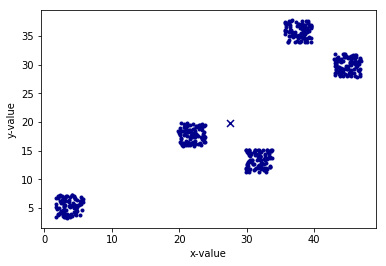

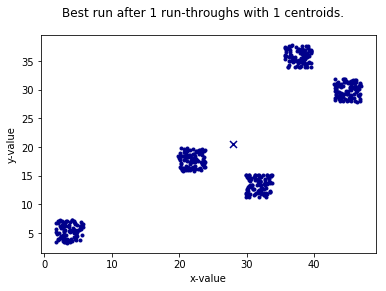

Programm stops after 1 runthroughs
Time it took for the result: 2.1730945110321045 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 41.2732204   32.92678989   0.           0.         184.
    0.           0.           1.           0.        ]
 [ 19.44852992  12.24105271   0.           0.         314.
    0.           0.           2.           0.        ]]


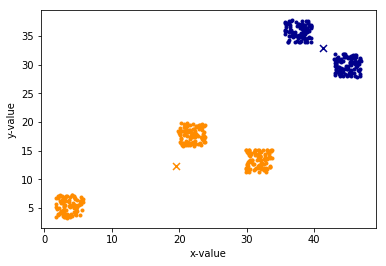

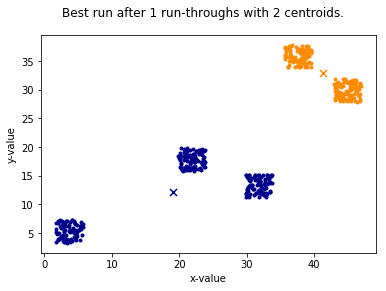

Programm stops after 1 runthroughs
Time it took for the result: 4.43810248374939 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 12.93791015  11.63491388   0.           0.         206.
    0.           0.           1.           0.        ]
 [ 41.2732204   32.92678989   0.           0.         184.
    0.           0.           2.           0.        ]
 [ 31.86693428  13.3972064    0.           0.         108.
    0.           0.           3.           0.        ]]


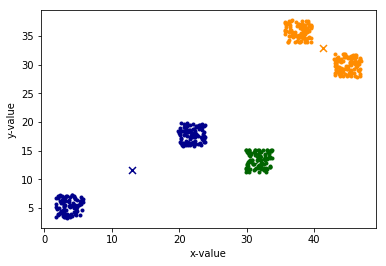

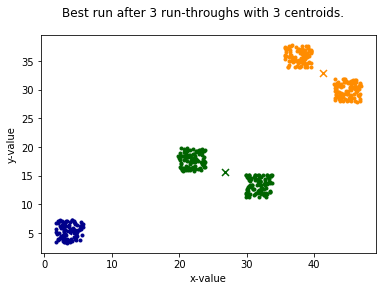

Programm stops after 3 runthroughs
Time it took for the result: 6.8308703899383545 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 44.95785174  29.93770441   0.           0.          90.
    0.           0.           1.           0.        ]
 [ 12.93791015  11.63491388   0.           0.         206.
    0.           0.           2.           0.        ]
 [ 31.86693428  13.3972064    0.           0.         108.
    0.           0.           3.           0.        ]
 [ 37.74538189  35.78868024   0.           0.          94.
    0.           0.           4.           0.        ]]


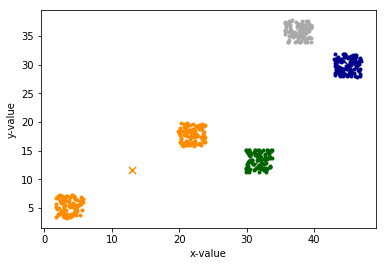

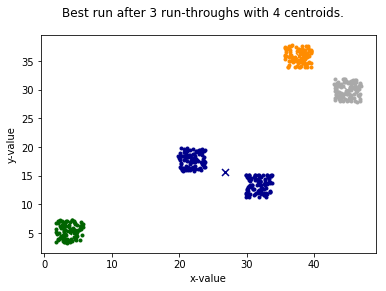

Programm stops after 3 runthroughs
Time it took for the result: 10.279365062713623 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 44.95785174  29.93770441   0.           0.          90.
    0.           0.           1.           0.        ]
 [ 21.83435661  17.62546871   0.           0.         106.
    0.           0.           2.           0.        ]
 [ 31.86693428  13.3972064    0.           0.         108.
    0.           0.           3.           0.        ]
 [ 37.74538189  35.78868024   0.           0.          94.
    0.           0.           4.           0.        ]
 [  3.50767691   5.28492577   0.           0.         100.
    0.           0.           5.           0.        ]]


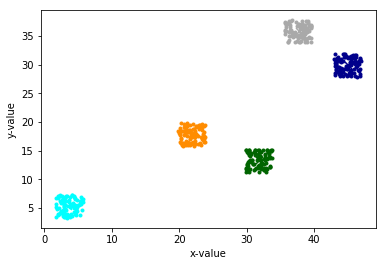

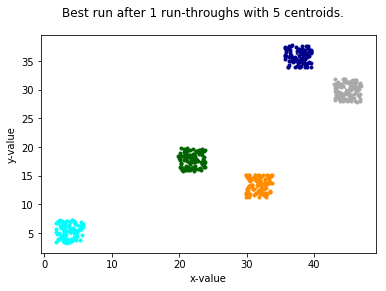

Programm stops after 1 runthroughs
Time it took for the result: 12.664419412612915 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 21.83435661  17.62546871   0.           0.         106.
    0.           0.           1.           0.        ]
 [ 44.95785174  29.93770441   0.           0.          90.
    0.           0.           2.           0.        ]
 [ 31.86693428  13.3972064    0.           0.         108.
    0.           0.           3.           0.        ]
 [ 36.89944336  36.50731316   0.           0.          41.
    0.           0.           4.           0.        ]
 [  3.50767691   5.28492577   0.           0.         100.
    0.           0.           5.           0.        ]
 [ 38.39978717  35.23275666   0.           0.          53.
    0.           0.           6.           0.        ]]


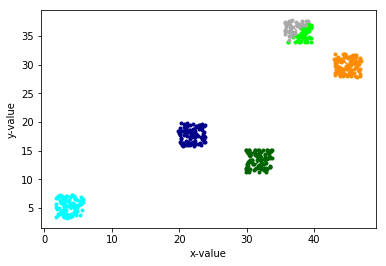

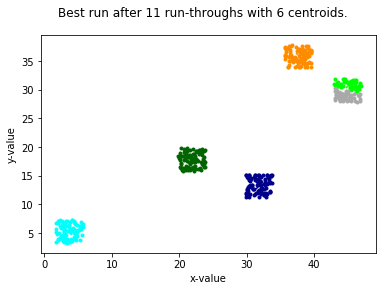

Programm stops after 11 runthroughs
Time it took for the result: 15.474910497665405 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 31.86693428  13.3972064    0.           0.         108.
    0.           0.           1.           0.        ]
 [ 37.74538189  35.78868024   0.           0.          94.
    0.           0.           2.           0.        ]
 [ 21.1594383   18.56010941   0.           0.          40.
    0.           0.           3.           0.        ]
 [ 45.50599032  29.25369511   0.           0.          47.
    0.           0.           4.           0.        ]
 [  3.50767691   5.28492577   0.           0.         100.
    0.           0.           5.           0.        ]
 [ 44.35872352  30.68534247   0.           0.          43.
    0.           0.           6.           0.        ]
 [ 22.24339801  17.0590198    0.           0.          66.
    0.           0.           7.           0.        ]]


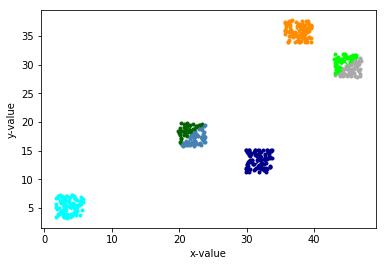

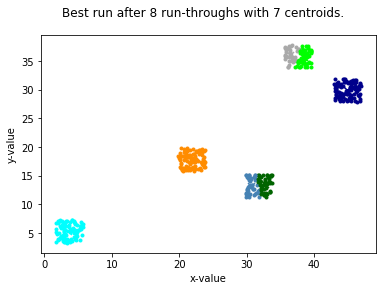

Programm stops after 8 runthroughs
Time it took for the result: 18.443719625473022 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 37.74538189  35.78868024   0.           0.          94.
    0.           0.           1.           0.        ]
 [ 31.40065102  12.40526422   0.           0.          51.
    0.           0.           2.           0.        ]
 [ 21.1594383   18.56010941   0.           0.          40.
    0.           0.           3.           0.        ]
 [ 45.50599032  29.25369511   0.           0.          47.
    0.           0.           4.           0.        ]
 [  3.50767691   5.28492577   0.           0.         100.
    0.           0.           5.           0.        ]
 [ 32.28413509  14.28473362   0.           0.          57.
    0.           0.           6.           0.        ]
 [ 44.35872352  30.68534247   0.           0.          43.
    0.           0.           7.           0.        ]
 [ 22.24339801  17.0590198    0.           0.          66.
    0

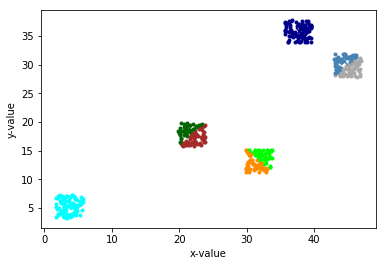

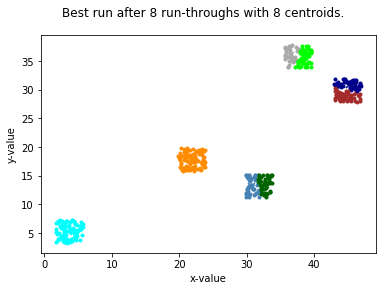

Programm stops after 8 runthroughs
Time it took for the result: 21.41175150871277 seconds.

 Centroid-Array after Mini-Batch run-through
[[37.74538189 35.78868024  0.          0.         94.          0.
   0.          1.          0.        ]
 [21.27817012 16.79624917  0.          0.         56.          0.
   0.          2.          0.        ]
 [32.39885124 12.83870884  0.          0.         66.          0.
   0.          3.          0.        ]
 [45.50599032 29.25369511  0.          0.         47.          0.
   0.          4.          0.        ]
 [ 4.35093305  6.03382201  0.          0.         43.          0.
   0.          5.          0.        ]
 [44.35872352 30.68534247  0.          0.         43.          0.
   0.          6.          0.        ]
 [22.45728548 18.55419459  0.          0.         50.          0.
   0.          7.          0.        ]
 [31.03106477 14.27484543  0.          0.         42.          0.
   0.          8.          0.        ]
 [ 2.87153631  4.719968

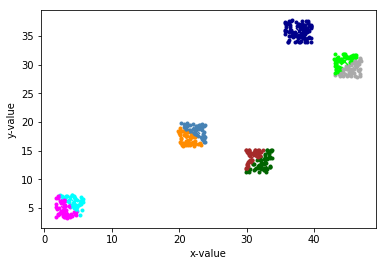

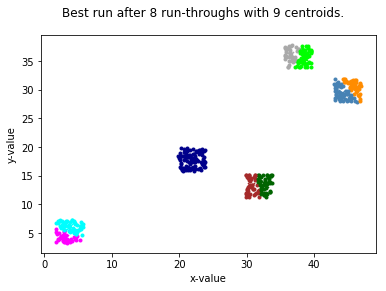

Programm stops after 8 runthroughs
Time it took for the result: 24.674181699752808 seconds.

 Centroid-Array after Mini-Batch run-through
[[ 3.94502881  5.89552936  0.          0.         67.          0.
   0.          1.          0.        ]
 [45.74079609 30.58176282  0.          0.         48.          0.
   0.          2.          0.        ]
 [31.49224601 12.31658047  0.          0.         51.          0.
   0.          3.          0.        ]
 [21.1594383  18.56010941  0.          0.         40.          0.
   0.          4.          0.        ]
 [36.89944336 36.50731316  0.          0.         41.          0.
   0.          5.          0.        ]
 [32.20218168 14.36408223  0.          0.         57.          0.
   0.          6.          0.        ]
 [38.39978717 35.23275666  0.          0.         53.          0.
   0.          7.          0.        ]
 [44.0630582  29.20163765  0.          0.         42.          0.
   0.          8.          0.        ]
 [22.24339801 17.05901

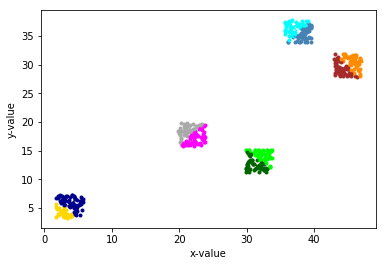

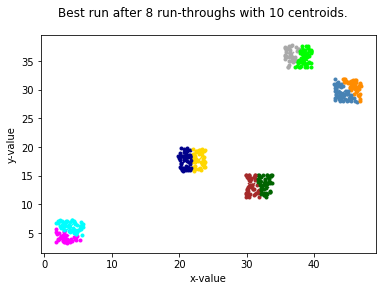

Programm stops after 8 runthroughs
Time it took for the result: 27.598057985305786 seconds.

Liste für ellbow:
[165581.27021737865, 54475.057005342635, 11510.215939203936, 7241.094912427618, 1352.7460608000185, 1240.0851760863338, 1143.6596948807194, 1030.9988101670347, 924.9558485251739, 831.0215743397722]


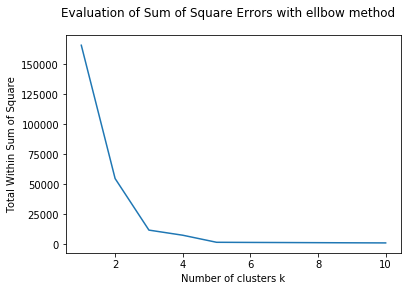


liste für silhouete:
[1.0, 0.7278722653605472, 0.8822403984513617, 0.8920641340524454, 0.9197201380969071, 0.9270916706606389, 0.9275813907124555, 0.8768605180822623, 0.9368547520536968, 0.8918909011029352]


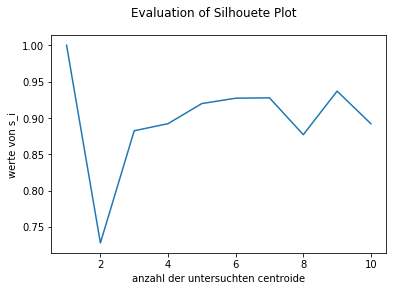

In [66]:
def main():
    
    #set timestamp
    start = time.time()
    
    #k_mean maximum is 10
    k_mean_max = 10
    
    #is number of centroids for each run through
    k_mean_for_init_centroids = 1
    
    #list to gather values for ellbow method
    liste_for_ellbow = []

    #how many cluster should data have
    cluster_guessed = 5

    #distribution of points around 1 cluster
    distribution = 2

    #number of points each cluster should have
    number_of_points = 100
    
    #how many mini batches? --> for K Mean- MiniBatch
    number_of_mini_batch = 3

    #create array of data points
    #style: cluster_guess + 3 dimension because: x-value, y-value, the closest centroid, distance to centroids, ....
    array = np.zeros((cluster_guessed*number_of_points, k_mean_max + 3))

    #(cluster_guessed, distribution, number of points each cluster)
    array = init_array_old(array, cluster_guessed, number_of_points, distribution)
    #array = load_data_and_PCA(k_mean_max)

    #create array of centroids and initialize
    #style:"cur_x", "cur_y", "old_x", "old_y", "counter", "score_x", "score_y", "number of centroid", "is changing koordinates?"

    #plot figure to enable plotting
    plt.figure()
    
    #liste von werten für silhouete plot
    list_for_silhouete = []


    #kmean normal run-through as well as miniBatch
    #with varying
    for i in range(0, k_mean_max):
        main_miniBatch(array, k_mean_for_init_centroids, number_of_mini_batch)
        
        start
        runner = 1
        centroids = np.zeros((k_mean_for_init_centroids, 9))
        centroids = init_centroids_new(array, centroids, k_mean_for_init_centroids)
        counter_runs = 0
        
        #from this point: normal k Mean run-through
        while runner:
            
            measure_distance(array, centroids)            
            closest_centroid(array, k_mean_for_init_centroids)
            reassign_centroid(array, centroids)
            counter_runs += 1   
            
            if evaluate_score(centroids, k_mean_for_init_centroids):
                runner=0
                counter_runs -= 1
                plt.suptitle("Best run after " + str(counter_runs) + " run-throughs with " + str(k_mean_for_init_centroids) + " centroids.")
                plot_array(array, centroids)
                k_mean_for_init_centroids += 1
                
                
            elif counter_runs == 51:
                runner=0
                counter_runs-=1
                print("Kmeans stopped after 50 runthroughs, because the calculations took to long")
                plt.suptitle("Best run after " + str(counter_runs) + " run-throughs with " + str(k_mean_for_init_centroids) + " centroids.")
                plot_array(array, centroids)
                k_mean_for_init_centroids += 1
            

        list_for_silhouete.append(silhouette_evaluation(array, centroids, k_mean_for_init_centroids-1))   
        evaluate_score_for_ellbow(array, centroids, liste_for_ellbow)
                

    
        print("Programm stops after " + str(counter_runs) + " runthroughs")

        end = time.time()

        zeit=end-start

        print("Time it took for the result: " + str(zeit) + " seconds.")
    

    print("\nListe für ellbow:")
    print(liste_for_ellbow)
    
    x_list = []
    for i in range(0, k_mean_max):
        x_list.append(i+1)
        
    plt.xlabel("Number of clusters k")
    plt.ylabel("Total Within Sum of Square")
    plt.suptitle("Evaluation of Sum of Square Errors with ellbow method")
    plt.plot(x_list, liste_for_ellbow)
    plt.show()
    
    print("\nliste für silhouete:")
    print(list_for_silhouete)
    
    plt.xlabel("anzahl der untersuchten centroide")
    plt.ylabel("werte von s_i")
    plt.suptitle("Evaluation of Silhouete Plot")
    plt.plot(x_list, list_for_silhouete)
    plt.show()
    
main()     


In [ ]:
#auswertung in panda dataframe